# One Neural Network

In [57]:
import gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras import optimizers
from collections import deque 

class DQNAgent():
    
    def __init__(self, state_space, action_space):
        self.state_space = state_space
        self.action_space = action_space
        
        self.learning_rate = 0.001
        self.discount_factor = 0.99
        self.epsilon = 0.1
        self.epsilon_decay_factor = 0.999
        
        self.memory = deque(maxlen=2000)  
        self.batch_size = 32
        
        self.model = self.build_model()
    
    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_space, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(units=self.action_space, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=optimizers.Adam(lr=self.learning_rate))
        return model
    
    def get_action(self, state):
        optimal_action = np.argmax(self.model.predict(state)[0])
        random_action = random.randint(0, self.action_space - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action
    
    def train_model(self):
        if len(self.memory) >= self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            
            state = np.zeros((self.batch_size, self.state_size))
            next_state = np.zeros((self.batch_size, self.state_size))
            action, reward, done = np.empty([self.batch_size]), np.empty([self.batch_size]), np.empty([self.batch_size])

            for i in range(self.batch_size):
                state[i] = mini_batch[i][0]
                action[i] = mini_batch[i][1]
                reward[i] = mini_batch[i][2]
                next_state[i] = mini_batch[i][3]
                done[i] = mini_batch[i][4]
                
            target = reward + self.discount_factor * np.max(self.model.predict(next_state),axis=1) * (np.ones(self.batch_size) - done)
            
            self.model.fit(state, target, epochs=1, verbose=0)

        self.epsilon *= self.epsilon_decay_factor

if __name__ == "__main__":

    env = gym.make('LunarLander-v2')
    agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    number_of_episodes = 
    total_reward = np.zeros(number_of_episodes)
    freq = 4

    for i in range(number_of_episodes):
        state = env.reset()
        state = np.reshape(state, [1,env.observation_space.shape[0]])
           
        while True:
            env.render()
           
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,env.observation_space.shape[0]])
                            
            agent.save_sample(state, action, reward, next_state, done)
                
            if i % freq == 0:
                agent.train_model()
            
            state = next_state
            total_reward[i] += reward

            if done:
                
                env.render()
                print("Episode {} ".format(i+1))
                
                break
          
    plt.plot(total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()
    env.close()

        

# Target Network

[2021-01-14 14:20:24,635] Making new env: LunarLander-v2


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 100)               900       
_________________________________________________________________
dense_64 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 404       
Total params: 21,504
Trainable params: 21,504
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 100)               900       
__________________________

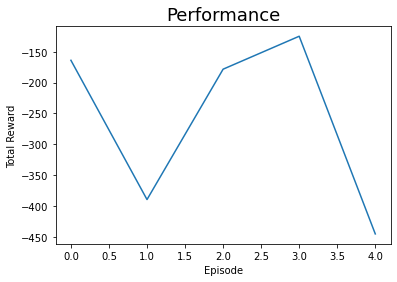

In [25]:
import gym
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras import optimizers
from collections import deque

class DQNAgent():

    def __init__(self, state_size, action_size):
        self.state_size = state_size  
        self.action_size = action_size  

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay_factor = 0.999
        self.epsilon_min = 0.01

        # Experience Replay technic คนละ Weight
        self.model = self.build_model()  # ใช้หา 1.Optimal action ในแต่ละ timestep, 2.ใช้คำนวน Q(s,a) ใน loss function
        self.target_model = self.build_model()  # Target model ใช้คำนวน (r + gamma * maxQ(s',a))

        self.update_target_model()

        self.memory = deque(maxlen=10000)  # memory for train
        self.batch_size = 64

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        optimal_action = np.argmax(self.model.predict(state)[0])
        random_action = random.randint(0, self.action_size - 1)
        action = np.random.choice([optimal_action, random_action], p=[1 - self.epsilon, self.epsilon])
        return action

    def build_model(self):
        model = Sequential()
        model.add(Dense(100, input_dim=self.state_size, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(units=self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=optimizers.Adam(lr=self.learning_rate))
        return model

    def save_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay_factor

    def train_model(self):
        if len(self.memory) >= self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)  # random sample for cut correlation

            update_state = np.zeros((self.batch_size, self.state_size))
            update_next_state = np.zeros((self.batch_size, self.state_size))
            action, reward, done = np.empty([self.batch_size]), np.empty([self.batch_size]), np.empty([self.batch_size])

            for i in range(self.batch_size):
                update_state[i] = mini_batch[i][0]
                action[i] = mini_batch[i][1]
                reward[i] = mini_batch[i][2]
                update_next_state[i] = mini_batch[i][3]
                done[i] = mini_batch[i][4]
                
            q_next = self.target_model.predict(update_next_state)
            q_current = self.model.predict(update_state)
            
            for i in range(self.batch_size):
                if done[i]:
                    q_current[i][action.astype(int)[i]] = reward[i]
                else:
                    q_current[i][action.astype(int)[i]] = reward[i] + self.discount_factor * (np.amax(q_next[i]))

            self.model.fit(update_state, q_current, epochs=1, verbose=0)
    def evaluate(self):
        n_sample = 10
        sample = random.sample(self.memory, n_sample)

        state = np.zeros((n_sample, self.state_size))
        next_state = np.zeros((n_sample, self.state_size))
        action, reward, done = np.empty([n_sample]), np.empty([n_sample]), np.empty([n_sample])

        for i in range(n_sample):
            state[i] = sample[i][0]
            action[i] = sample[i][1]
            reward[i] = sample[i][2]
            next_state[i] = sample[i][3]
            done[i] = sample[i][4]

        target = reward + self.discount_factor * np.max(self.target_model.predict(next_state), axis=1) * (np.ones(n_sample) - done)
        loss = self.model.evaluate(state, target)
        
        return loss
        
        
if __name__ == "__main__":

    env = gym.make('LunarLander-v2')
    agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    number_of_episodes = 5
    total_reward = np.zeros(number_of_episodes)
    loss = np.zeros(number_of_episodes)
    freq = 4
    
    

    for i in range(number_of_episodes):
        count = 0
        state = env.reset()
        state = np.reshape(state, [1,env.observation_space.shape[0]])
           
        while True:
            count += 1
            
            env.render()
           
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1,env.observation_space.shape[0]])
                            
            agent.save_sample(state, action, reward, next_state, done)
                
            if count % freq == 0:
                agent.train_model()
            
            state = next_state
            total_reward[i] += reward

            if done:
                env.render()
                agent.update_target_model()
                loss[i] = agent.evaluate()
                
                text_file = open("text.txt", "a") 
                text_file.write('{}\n{}\n'.format(total_reward[i], loss[i]))
                text_file.close()
                
                print("Episode:{}, Reward:{} ".format(i+1, total_reward[i]))
                
                break
          
    plt.plot(total_reward)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Performance',fontsize=18)
    plt.show()
    env.close()

In [27]:
len(agent.memory)

493

In [37]:
mini_batch = random.sample(agent.memory, 10)

update_state = np.zeros((10, 8))
update_next_state = np.zeros((10, 8))
action, reward, done = np.empty([10]), np.empty([10]), np.empty([10])

for i in range(10):
    update_state[i] = mini_batch[i][0]
    action[i] = mini_batch[i][1]
    reward[i] = mini_batch[i][2]
    update_next_state[i] = mini_batch[i][3]
    done[i] = mini_batch[i][4]

In [42]:
agent.model.predict(update_state)

array([[-7.77944028e-01, -4.77170438e-01,  4.79549646e-01,
         2.88687758e-02],
       [-4.47368145e+00, -4.33027792e+00, -2.61123157e+00,
        -5.50819445e+00],
       [-8.52048814e-01, -5.31866550e-01,  4.95877147e-01,
        -1.51146606e-01],
       [-1.27710128e+00, -9.94715691e-01,  5.97776592e-01,
        -1.20399952e+00],
       [-1.29534006e+00, -1.04659224e+00,  6.36806071e-01,
        -1.20296431e+00],
       [-1.08588326e+02, -1.07562897e+02, -7.21214066e+01,
        -1.82367725e+01],
       [-5.40658617e+00, -5.21961832e+00, -6.23760891e+00,
        -7.69423199e+00],
       [-9.31080341e+00, -9.62085056e+00, -1.22150946e+01,
        -1.12941437e+01],
       [-6.85214949e+00, -8.27054501e+00, -1.83044326e+00,
         6.09834015e-01],
       [-1.14530218e+00, -8.55235457e-01,  4.67283458e-01,
        -1.11156750e+00]], dtype=float32)

In [43]:
np.max(agent.model.predict(update_state),axis=1) 

array([  0.47954965,  -2.6112316 ,   0.49587715,   0.5977766 ,
         0.6368061 , -18.236773  ,  -5.2196183 ,  -9.310803  ,
         0.609834  ,   0.46728346], dtype=float32)

In [45]:
reward

array([  -3.65668311,    0.32775947,   -1.76536959,   -2.80332887,
          0.10513322, -100.        ,   -2.2345105 ,   -4.75365664,
         -1.07360428,   -2.039778  ])

In [47]:
np.max(agent.model.predict(update_state),axis=1) + reward 

array([  -3.17713346,   -2.28347209,   -1.26949244,   -2.20555228,
          0.74193929, -118.23677254,   -7.45412882,  -14.06446005,
         -0.46377026,   -1.57249454])